In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, roc_curve, confusion_matrix

from scipy.sparse import hstack

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

##### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

In [3]:
df.drop(columns=['CustomerId'], inplace=True)

In [4]:
df.head(2)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


Посмотрим на распределение классов:

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Зададим списки признаков

In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [9]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
6252,0,1
4684,0,1
1731,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [10]:
age = Pipeline([
                ('selector', NumberSelector(key='Age')),
                ('standard', StandardScaler())
            ])
age.fit(X_train)
age.transform(X_test)

array([[-0.65514605],
       [ 0.3926101 ],
       [ 0.48786066],
       ...,
       [-1.32189996],
       [-0.27414381],
       [-1.32189996]])

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [11]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])

    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модели

In [13]:
pipeline_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

pipeline_forest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline_boosting = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

Обучим модели

In [14]:
pipeline_logreg.fit(X_train, y_train)
pipeline_forest.fit(X_train, y_train)
pipeline_boosting.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Прогнозируем

In [15]:
preds_logreg = pipeline_logreg.predict_proba(X_test)[:, 1]
preds_logreg[:10]

array([0.24240617, 0.08200887, 0.31150697, 0.4332125 , 0.06344218,
       0.04561937, 0.27221178, 0.20881274, 0.32279263, 0.31023216])

In [16]:
preds_forest = pipeline_forest.predict_proba(X_test)[:, 1]
preds_forest[:10]

array([0.02, 0.01, 0.23, 0.11, 0.1 , 0.  , 0.18, 0.28, 0.38, 0.36])

In [17]:
preds_boosting = pipeline_boosting.predict_proba(X_test)[:, 1]
preds_boosting[:10]

array([0.04024904, 0.03753384, 0.09999524, 0.21626635, 0.09478458,
       0.01926406, 0.12068039, 0.22125588, 0.32016528, 0.34830405])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [54]:
def calc_metrics(y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fscore = (2 * precision * recall) / (precision + recall + 1e-10)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return (thresholds[ix], fscore[ix], precision[ix], recall[ix])

In [55]:
logreg_metrics = calc_metrics(y_test, preds_logreg)
forest_metrics = calc_metrics(y_test, preds_forest)
boosting_metrics = calc_metrics(y_test, preds_boosting)

In [56]:
data = [logreg_metrics, forest_metrics, boosting_metrics]
index = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier']

metrics = pd.DataFrame(data, index=index, columns=['Threshold', 'F-score', 'Precision', 'Recall'])

In [57]:
metrics

,Threshold,F-score,Precision,Recall
LogisticRegression,0.274065,0.502609,0.442573,0.581489
RandomForestClassifier,0.360000,0.619395,0.642857,0.597586
GradientBoostingClassifier,0.271906,0.641580,0.602473,0.686117


In [58]:
ras_logreg = roc_auc_score(y_true=y_test, y_score=pipeline_logreg.fit(X_train, y_train).predict_proba(X_test)[:,1])

In [59]:
ras_forest = roc_auc_score(y_true=y_test, y_score=pipeline_forest.fit(X_train, y_train).predict_proba(X_test)[:,1])

In [60]:
ras_boosting = roc_auc_score(y_true=y_test, y_score=pipeline_boosting.fit(X_train, y_train).predict_proba(X_test)[:,1])

Добавим в датафрейм столбес с метрикой ro_auc_score

In [61]:
metrics['Roc_Auc_Score'] = [ras_logreg, ras_forest, ras_boosting]

In [62]:
metrics

,Threshold,F-score,Precision,Recall,Roc_Auc_Score
LogisticRegression,0.274065,0.502609,0.442573,0.581489,0.773358
RandomForestClassifier,0.360000,0.619395,0.642857,0.597586,0.854112
GradientBoostingClassifier,0.271906,0.641580,0.602473,0.686117,0.865666


Очень странное значение порога для logreg.

Отрисуем матрицу ошибок

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
def make_confusion_matrix(y_score, threshold):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>threshold)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['churn', 'non_churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

Confusion matrix, without normalization
[[1639  364]
 [ 209  288]]


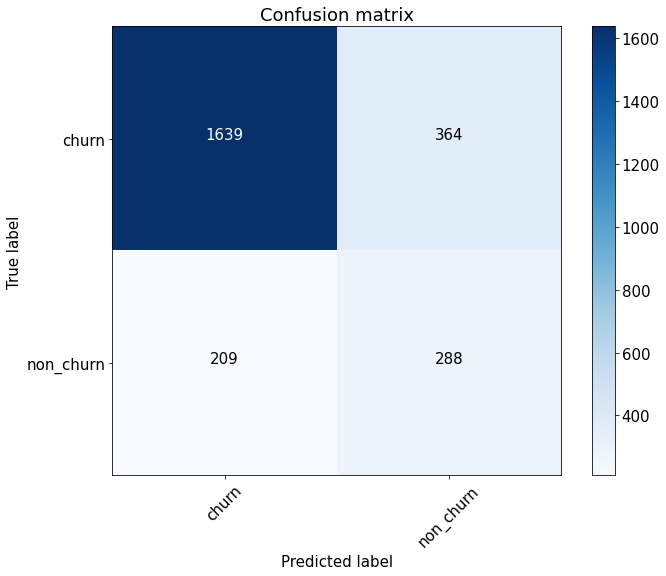

In [65]:
make_confusion_matrix(preds_logreg, logreg_metrics[0])

Confusion matrix, without normalization
[[1852  151]
 [ 210  287]]


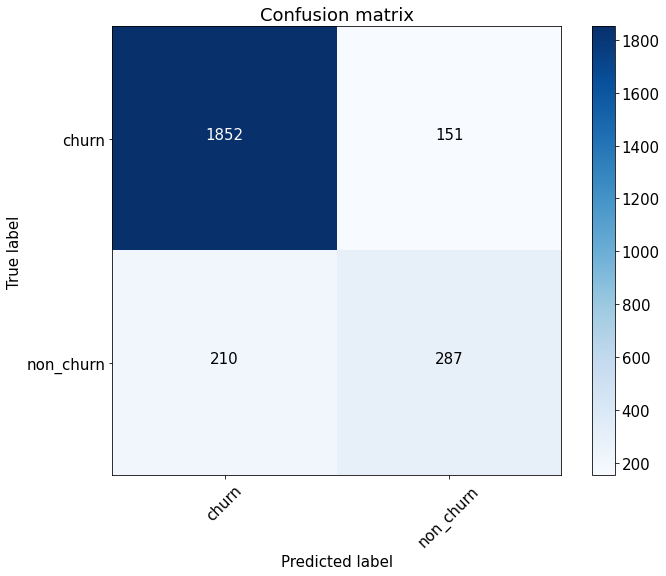

In [66]:
make_confusion_matrix(preds_forest, forest_metrics[0])

Confusion matrix, without normalization
[[1778  225]
 [ 157  340]]


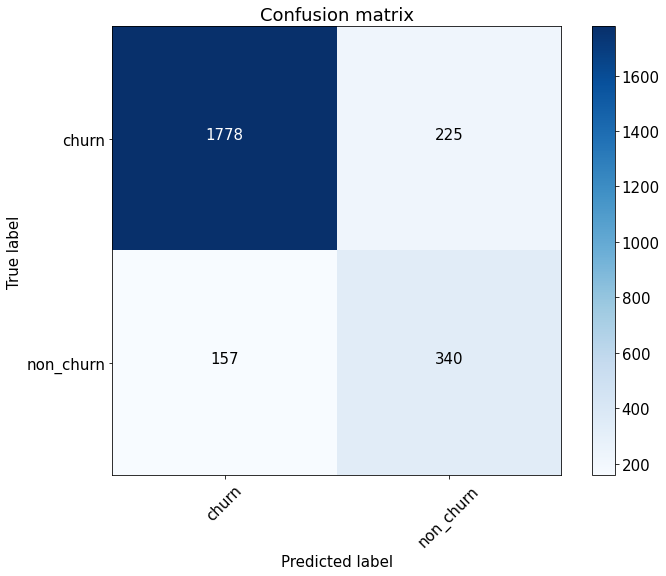

In [67]:
make_confusion_matrix(preds_boosting, boosting_metrics[0])

##### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

По метрикам лучшая модель - pipeline_boosting. Наиболее подхлдящие метрики - F-score и Roc_Auc, которые не зависят от уровня дисбаланса классов.

##### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

In [72]:
cnf_matrix = confusion_matrix(y_test, preds_boosting>metrics['Threshold']['GradientBoostingClassifier'])
cnf_matrix

array([[1778,  225],
       [ 157,  340]])

Profit = Revenue - Expenditures. 
Выручка = 2 дол
Расходы = 1 дол

По TP мы получим по 2 дол, а потратим - по 1 дол на TP и FP (тех, кого модель ошибочно оценила как уходящих).

In [73]:
profit = 2*cnf_matrix[1, 1]-(cnf_matrix[0, 1]+cnf_matrix[1, 1])
profit

115

Результат - 115 дол, следовательно, модель работает.